## Алексеев Д.П. (DSU-4,CVML-4)_HW #1 (Digit Recognizer)

https://www.kaggle.com/c/digit-recognizer

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [2]:
train = np.loadtxt('E:\\Netology\\Computer Vision\\Practice\\Digit-recognizer\\train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('E:\\Netology\\Computer Vision\\Practice\\Digit-recognizer\\test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

## Визуализируем исходные данные

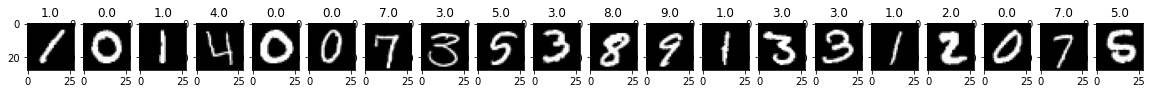

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:20], 1):
    subplot = fig.add_subplot(1, 20, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

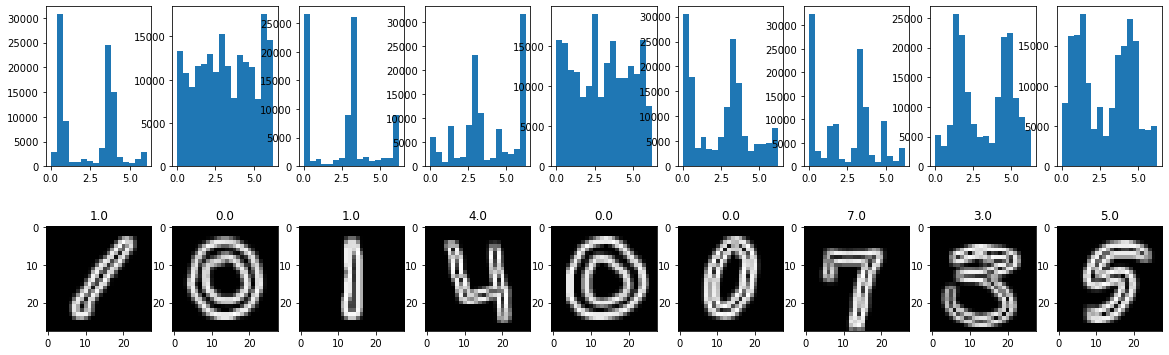

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:9], 1):
    subplot = fig.add_subplot(1, 9, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 9, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=21)

## В качестве модели для классификации используем усовершенствованный алогоритм случайного леса. 

In [16]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()

In [17]:
model.fit(x_train, y_train)

ExtraTreesClassifier()

## Оцениваем качество решения на валидационной выборке

In [18]:
from sklearn.metrics import accuracy_score

pred_val = model.predict(x_val)

print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.6545238095238095


## Точность предсказаний получилась не очень высокой (на уровне 65%), но это удовлетворяет условиям задачи (не менее 60%).

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.45      0.42      0.43       814
         1.0       0.98      0.96      0.97       893
         2.0       0.53      0.49      0.51       796
         3.0       0.60      0.72      0.65       828
         4.0       0.70      0.72      0.71       829
         5.0       0.69      0.65      0.67       806
         6.0       0.51      0.48      0.50       888
         7.0       0.83      0.78      0.81       886
         8.0       0.56      0.61      0.58       803
         9.0       0.66      0.69      0.67       857

    accuracy                           0.65      8400
   macro avg       0.65      0.65      0.65      8400
weighted avg       0.66      0.65      0.65      8400



## Мы видим, что наиболее точно предсказываются цифры 1, 7, 4, 9, 3, 5. 
## Хуже всего почему-то 0 (44%).

In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[339   8  65  33  24  15 126  10 157  37]
 [  0 855   4   0  21   0   2   5   0   6]
 [ 39   0 390 123   2  90  54  20  53  25]
 [ 14   0  69 595   1  74  11   5  48  11]
 [ 16   6   4   6 596   1  75  40   5  80]
 [ 11   0  89 123   1 523  11   7  34   7]
 [159   1  45  19  83  13 430  14  63  61]
 [  8   5  16   5  61   9  35 694   6  47]
 [106   0  34  72   3  29  41   2 486  30]
 [ 65   1  20  13  54   5  50  36  23 590]]


## Вычисляем центроиды каждого из 10 классов.

In [21]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [22]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

## Предсказания на тестовых данных

In [23]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

## Визуализируем предсказания

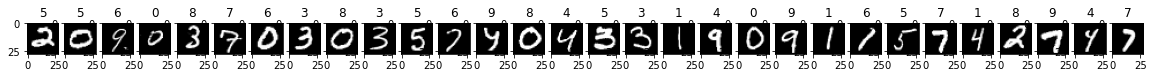

In [24]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:30], 1):
    subplot = fig.add_subplot(1, 30, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Мы видим, что результат приблизительно соответствует classification_report. 
## Качество предсказаний могло быть гораздо лучше, но только на нейронной сети, как полагаю))

## Готовим файл для отправки

In [26]:
result = model.predict(test_hist)

with open('submit_3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(result, 1):
        dst.write('%s,%s\n' % (i, str(p).replace('.0', '')))